# RITAL - Bag of Words Project

Binôme :
- **Ben KABONGO**, 21116436

- **Sofia BORCHANI**, 21212080

## Partie I : Données reconnaissance du locuteur (Chirac/Mitterrand) : étude du temps et comparaison de modèles

Dans cette section, nous étudions les temps d'exécutions et les performances des différents modèles.

**Problématiques :**
- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils
import warnings
import time

from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import (linear_model, 
                     ensemble,
                     tree,
                     decomposition, 
                     naive_bayes, 
                     svm,
                     metrics,
                     preprocessing, 
                     model_selection, 
                     pipeline,)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
plt.style.use('seaborn-whitegrid')
warnings.simplefilter("ignore")

### Chargement des données

In [3]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
all_locuteur_df = utils.load_pres(fname)
all_locuteur_df

,text,label
0,"Quand je dis chers amis, il ne s'agit pas là ...",1
1,D'abord merci de cet exceptionnel accueil que...,1
2,C'est toujours très émouvant de venir en Afri...,1
3,Aucun citoyen français ne peut être indiffére...,1
4,"Le Congo, que naguère le <nom> qualifia de ""r...",1
...,...,...
57408,Je suis heureux de le mener avec vous.\n,1
57409,"Vous le savez, comme vous, j'ai la passion de...",1
57410,Je crois en son avenir.\n,1
57411,"Je crois en la politique, c'est-à-dire en not...",1


In [4]:
y = all_locuteur_df.label

### Evaluations du temps d'apprentissage

In [5]:
# taille du vocabulaire
sizes = [10, 100, 1000, 10_000, 20_000, 40_000, 50_000, 80_000, 100_000]

In [6]:
# fonction de preprocessing : suppression de balise, mots maj, chiffres, ponctuation
f = lambda doc: utils.delete_balise( utils.replace_maj_word( utils.delete_digit( utils.delete_punctuation(doc) ) ) )

In [7]:
datasets = {}

for s in sizes:
    cv = CountVectorizer(preprocessor=f, ngram_range=(1, 3), stop_words=stopwords.words('french'), 
                     tokenizer=word_tokenize, lowercase=True, max_features=s)

    X = cv.fit_transform(all_locuteur_df.text)

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.2, random_state=0)
    
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    datasets[s] = [X_resampled, X_test, y_resampled, y_test]

#### Regression logistique

In [8]:
times_rl = []
accuracy_rl = []
f1_score_rl = []
balanced_accuracy_rl = []

print('----------------------- Logistic Regression -----------------------')

for s in sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = linear_model.LogisticRegression()
    t = time.time()
    clf.fit(X_train, y_train)
    t = (time.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_rl.append(t)
    accuracy_rl.append(acc)
    f1_score_rl.append(f1)
    balanced_accuracy_rl.append(balanced_acc)

    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('-------------------------------------------------------------------')


----------------------- Logistic Regression -----------------------
	Vocabulary Size 	: 10
	Learning Time 		: 25.908946990966797
	Accuracy 		: 0.6028912305146739
	F1 Score 		: 0.7311954727658572
	Balanced accuracy 	: 0.5238696850640656
-------------------------------------------------------------------
	Vocabulary Size 	: 100
	Learning Time 		: 44.47603225708008
	Accuracy 		: 0.6916311068536097
	F1 Score 		: 0.7991377843326338
	Balanced accuracy 	: 0.5773850694152953
-------------------------------------------------------------------
	Vocabulary Size 	: 1000
	Learning Time 		: 103.49488258361816
	Accuracy 		: 0.7481494383000958
	F1 Score 		: 0.8383815804180172
	Balanced accuracy 	: 0.6265089677294982
-------------------------------------------------------------------
	Vocabulary Size 	: 10000
	Learning Time 		: 194.93818283081055
	Accuracy 		: 0.7923887485848646
	F1 Score 		: 0.8695842450765865
	Balanced accuracy 	: 0.6595950487191946
---------------------------------------------------

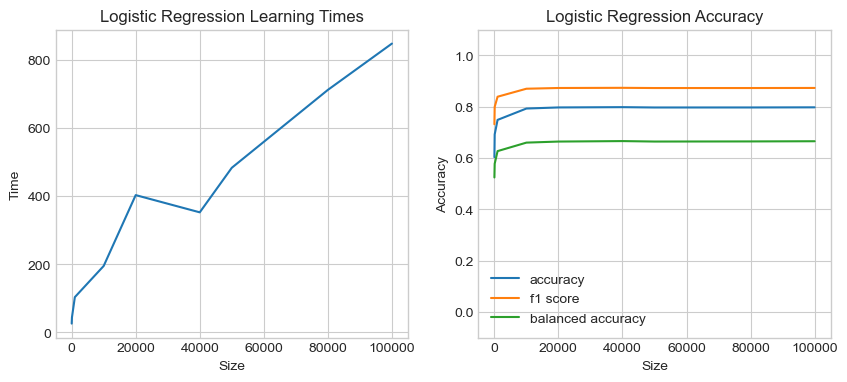

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Logistic Regression Learning Times')
axes[0].plot(sizes, times_rl)
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')

axes[1].set_title('Logistic Regression Accuracy')
axes[1].plot(sizes, accuracy_rl, label='accuracy')
axes[1].plot(sizes, f1_score_rl, label='f1 score')
axes[1].plot(sizes, balanced_accuracy_rl, label='balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

#### Naive Bayes

In [10]:
times_nv = []
accuracy_nv = []
f1_score_nv = []
balanced_accuracy_nv = []

print('--------------------------- Naive Bayes ----------------------------')

for s in sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = naive_bayes.MultinomialNB()
    t = time.time()
    clf.fit(X_train, y_train)
    t = (time.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_nv.append(t)
    accuracy_nv.append(acc)
    f1_score_nv.append(f1)
    balanced_accuracy_nv.append(balanced_acc)

    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('-------------------------------------------------------------------')


--------------------------- Naive Bayes ----------------------------
	Vocabulary Size 	: 10
	Learning Time 		: 3.910064697265625
	Accuracy 		: 0.3119393886614996
	F1 Score 		: 0.37318524395081315
	Balanced accuracy 	: 0.5164541599061419
-------------------------------------------------------------------
	Vocabulary Size 	: 100
	Learning Time 		: 1.2412071228027344
	Accuracy 		: 0.5969694330749804
	F1 Score 		: 0.7150597217091492
	Balanced accuracy 	: 0.5637052957664095
-------------------------------------------------------------------
	Vocabulary Size 	: 1000
	Learning Time 		: 1.4450550079345703
	Accuracy 		: 0.7249847600801185
	F1 Score 		: 0.8192950331883726
	Balanced accuracy 	: 0.6235850461646969
-------------------------------------------------------------------
	Vocabulary Size 	: 10000
	Learning Time 		: 1.895904541015625
	Accuracy 		: 0.7772359139597667
	F1 Score 		: 0.8569671214493402
	Balanced accuracy 	: 0.6609891470761715
--------------------------------------------------

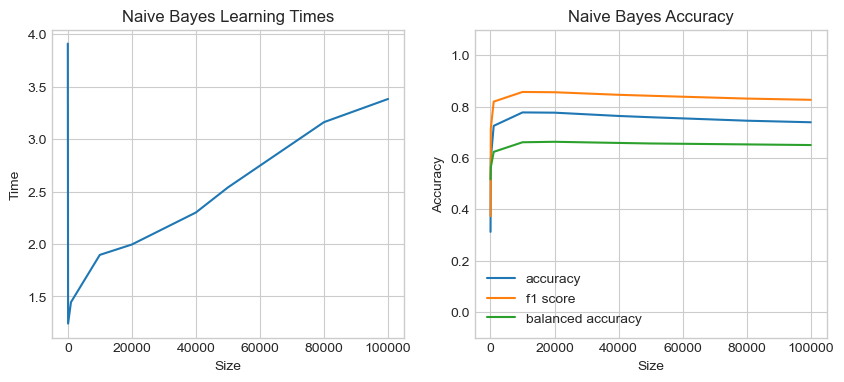

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Naive Bayes Learning Times')
axes[0].plot(sizes, times_nv)
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')

axes[1].set_title('Naive Bayes Accuracy')
axes[1].plot(sizes, accuracy_nv, label='accuracy')
axes[1].plot(sizes, f1_score_nv, label='f1 score')
axes[1].plot(sizes, balanced_accuracy_nv, label='balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

#### Regression logistique vs Naive Bayes

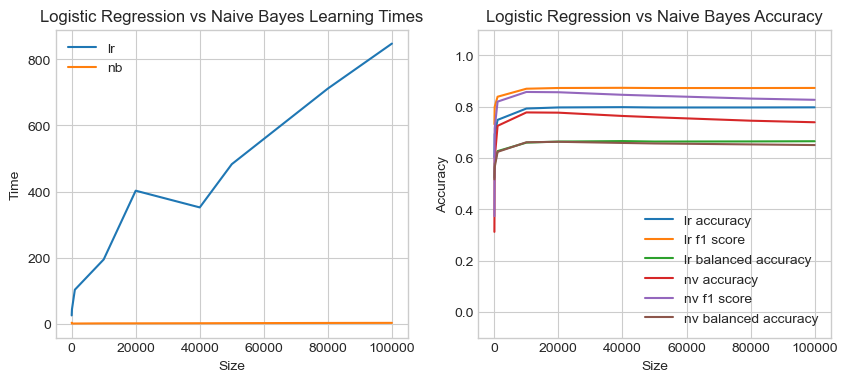

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Logistic Regression vs Naive Bayes Learning Times')
axes[0].plot(sizes, times_rl, label='lr')
axes[0].plot(sizes, times_nv, label='nb')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')
axes[0].legend()

axes[1].set_title('Logistic Regression vs Naive Bayes Accuracy')
axes[1].plot(sizes, accuracy_rl, label='lr accuracy')
axes[1].plot(sizes, f1_score_rl, label='lr f1 score')
axes[1].plot(sizes, balanced_accuracy_rl, label='lr balanced accuracy')
axes[1].plot(sizes, accuracy_nv, label='nv accuracy')
axes[1].plot(sizes, f1_score_nv, label='nv f1 score')
axes[1].plot(sizes, balanced_accuracy_nv, label='nv balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

`Le modèle Naive Bayes s'entraine relativement plus rapidement que le modèle de Regression Logistique, cependant on constante que les performances du modèle de Regression Logistique sont nettement meilleures que celles du modèle Naive Bayes.`

#### Support Vector

In [13]:
times_svm = []
accuracy_svm = []
f1_score_svm = []
balanced_accuracy_svm = []

print('--------------------------- Support Vector --------------------------')

for s in sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = svm.SVC()
    t = time.time()
    clf.fit(X_train, y_train)
    t = (time.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_svm.append(t)
    accuracy_svm.append(acc)
    f1_score_svm.append(f1)
    balanced_accuracy_svm.append(balanced_acc)

    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('-------------------------------------------------------------------')


--------------------------- Support Vector --------------------------
	Vocabulary Size 	: 10
	Learning Time 		: 2452.5938034057617
	Accuracy 		: 0.6774362100496386
	F1 Score 		: 0.7950420540061974
	Balanced accuracy 	: 0.5314540526993371
-------------------------------------------------------------------
	Vocabulary Size 	: 100
	Learning Time 		: 4081.5091133117676
	Accuracy 		: 0.6927632151876687
	F1 Score 		: 0.7995226730310262
	Balanced accuracy 	: 0.5805738489792467
-------------------------------------------------------------------
	Vocabulary Size 	: 1000
	Learning Time 		: 7278.064966201782
	Accuracy 		: 0.7456239658625795
	F1 Score 		: 0.8362392779054773
	Balanced accuracy 	: 0.6267326586579708
-------------------------------------------------------------------
	Vocabulary Size 	: 10000
	Learning Time 		: 15214.555025100708
	Accuracy 		: 0.7860315248628407
	F1 Score 		: 0.8652443371908078
	Balanced accuracy 	: 0.6540284874580012
-------------------------------------------------

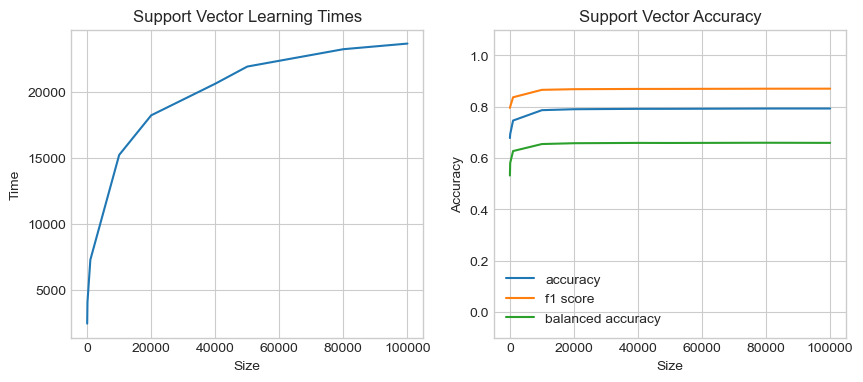

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Support Vector Learning Times')
axes[0].plot(sizes, times_svm)
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')

axes[1].set_title('Support Vector Accuracy')
axes[1].plot(sizes, accuracy_svm, label='accuracy')
axes[1].plot(sizes, f1_score_svm, label='f1 score')
axes[1].plot(sizes, balanced_accuracy_svm, label='balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

#### Regression Logitique vs SVM

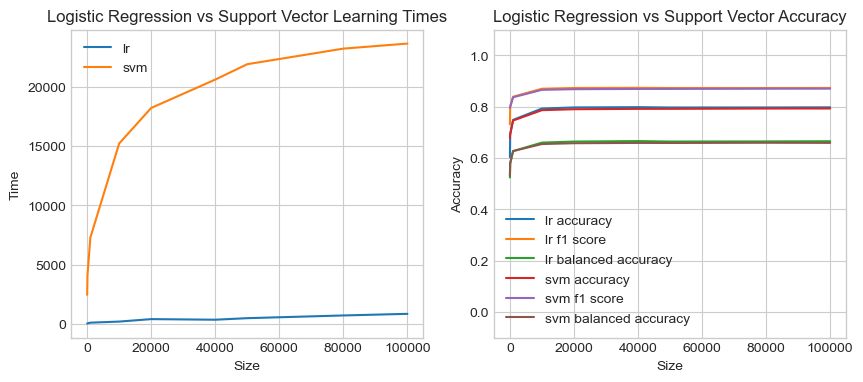

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Logistic Regression vs Support Vector Learning Times')
axes[0].plot(sizes, times_rl, label='lr')
axes[0].plot(sizes, times_svm, label='svm')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')
axes[0].legend()

axes[1].set_title('Logistic Regression vs Support Vector Accuracy')
axes[1].plot(sizes, accuracy_rl, label='lr accuracy')
axes[1].plot(sizes, f1_score_rl, label='lr f1 score')
axes[1].plot(sizes, balanced_accuracy_rl, label='lr balanced accuracy')
axes[1].plot(sizes, accuracy_svm, label='svm accuracy')
axes[1].plot(sizes, f1_score_svm, label='svm f1 score')
axes[1].plot(sizes, balanced_accuracy_svm, label='svm balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

`Le temps d'apprentissage du SVM est beaucoup plus long que le temps d'apprentissage de la regression logistique. Cependant, les performances des deux modèles sont presque équivalentes.`

Choix du modèle : **Regression Logistique**.

### Validation croisée / Train-test split

In [16]:
cv = CountVectorizer(preprocessor=f, ngram_range=(1, 2), stop_words=stopwords.words('french'), 
                     tokenizer=word_tokenize, lowercase=True, max_features=5_000)

X = cv.fit_transform(all_locuteur_df.text)
y = all_locuteur_df.label

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

lr = linear_model.LogisticRegression(random_state=42, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Train/test :')
print('\tAccuracy:', metrics.accuracy_score(y_test, y_pred))
print('\tPrecision:', metrics.precision_score(y_test, y_pred))
print('\tRecall:', metrics.recall_score(y_test, y_pred))
print('\tf1-score:', metrics.f1_score(y_test, y_pred))

print('Validation croisée :')
print('\tAccuracy:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5)))
print('\tPrecision:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5, scoring='precision')))
print('\tRecall:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5, scoring='recall')))
print('\tf1-score:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5, scoring='f1')))


Train/test :
	Accuracy: 0.7710963455149502
	Precision: 0.7612231620039037
	Recall: 0.7841823056300268
	f1-score: 0.7725321888412018
Validation croisée :
	Accuracy: 0.767445724840981
	Precision: 0.7603929485605279
	Recall: 0.7809384498480243
	f1-score: 0.7705185220137606


### Validation croisée : stabilité

In [17]:
cv = CountVectorizer(preprocessor=f, ngram_range=(1, 2), stop_words=stopwords.words('french'), 
                     tokenizer=word_tokenize, lowercase=True, max_features=5_000)

X = cv.fit_transform(all_locuteur_df.text)
y = all_locuteur_df.label

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

num_folds = 10

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

for seed in range(10):
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    clf = linear_model.LogisticRegression(random_state=seed)
    
    cv_results = model_selection.cross_validate(clf, X_resampled, y_resampled, cv=skf, 
                                scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    acc_scores.append(np.mean(cv_results['test_accuracy']))
    prec_scores.append(np.mean(cv_results['test_precision']))
    rec_scores.append(np.mean(cv_results['test_recall']))
    f1_scores.append(np.mean(cv_results['test_f1']))

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)
mean_prec = np.mean(prec_scores)
std_prec = np.std(prec_scores)
mean_rec = np.mean(rec_scores)
std_rec = np.std(rec_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f'Mean accuracy: {mean_acc:.4f} +/- {std_acc:.4f}')
print(f'Mean precision: {mean_prec:.4f} +/- {std_prec:.4f}')
print(f'Mean recall: {mean_rec:.4f} +/- {std_rec:.4f}')
print(f'Mean F1-score: {mean_f1:.4f} +/- {std_f1:.4f}')


Mean accuracy: 0.7761 +/- 0.0010
Mean precision: 0.7719 +/- 0.0014
Mean recall: 0.7840 +/- 0.0016
Mean F1-score: 0.7778 +/- 0.0010


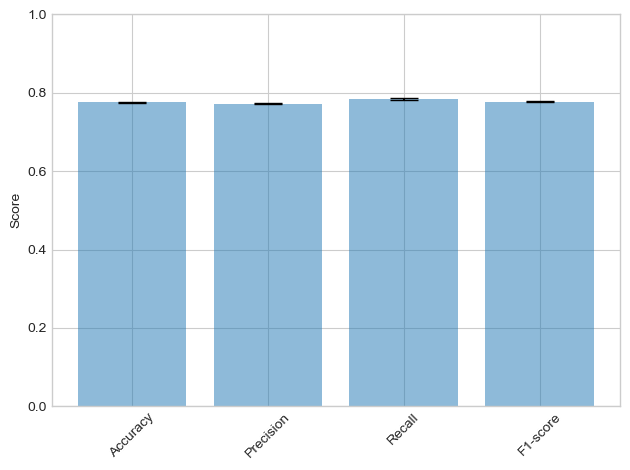

In [18]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
means = [mean_acc, mean_prec, mean_rec, mean_f1]
stds = [std_acc, std_prec, std_rec, std_f1]

fig, ax = plt.subplots()
ax.bar(metrics, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_xticklabels(metrics, rotation=45)
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()